In [4]:
# Imports cell
import pydicom
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


ERROR: Could not find a version that satisfies the requirement tensorflow-io==0.25.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-io==0.25.0


In [5]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
from functools import partial

In [6]:
# Functions used throughout project
def get_label_dict(filename):
     df = pd.read_csv(filename,index_col='SOPInstanceUID')
     df = df['Target'].str.split().apply(lambda x: [int(i) for i in x])
     # print(label_list)
     return df.to_dict()
     
def get_files():
     return glob('train/train/train/*/*/*/*'), glob('test/test/test/*/*/*/*') 

classes_to_body_parts = {
    0: 'Abdomen',
    1:'Ankle',
    2: 'Cervical Spine',
    3: 'Chest',
    4: 'Clavicles',
    5: 'Elbow',
    6: 'Feet',
    7: 'Finger',
    8: 'Forearm',
    9: 'Hand',
    10: 'Hip',
    11: 'Knee',
    12: 'Lower Leg',
    13: 'Lumbar Spine',
    14: 'Others',
    15: 'Pelvis',
    16: 'Shoulder',
    17: 'Sinus',
    18: 'Skull',
    19: 'Thigh',
    20: 'Thoracic Spine',
    21: 'Wrist'
}

def get_label_from_SOPID(index):
    return train_label_dict[index]

def load_train_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])

     
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     data['Label'] = data['index'].apply(get_label_from_SOPID)
     return data

def load_tf_train_data(files, labels):

     # step 2: create a dataset returning slices of `filenames`
     dataset = tf.data.Dataset.from_tensor_slices((files, labels))

     def im_file_to_tensor(file, label):
          def _im_file_to_tensor(file, label):
               im = tfio.image.decode_(tf.io.read_file(file), channels=3)
               im = tf.cast(im, tf.float32) / 255.0
               return im, label
          return tf.py_function(_im_file_to_tensor, 
                                   inp=(file, label), 
                                   Tout=(tf.float32, tf.uint8))

     dataset = dataset.map(im_file_to_tensor)

def load_test_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     return data

def show_images(image_files, num_images = 20, class_names = None, exp_equal = False, others = False):
     body_labels = [classes_to_body_parts[_class[0]] for _class in class_names[:num_images]]
     for i, (im,lbl) in enumerate(zip(image_files[:num_images], body_labels)):
        plt.subplot(7, 10, i+1)
        if lbl is not None:
                plt.title(lbl if class_names is None else lbl)
        if (exp_equal):  
          plt.imshow(exp.equalize_hist(pydicom.dcmread(im).pixel_array), cmap='binary', interpolation='bilinear')
        else: 
          plt.imshow(pydicom.dcmread(im).pixel_array, cmap='binary', interpolation='bilinear')

        plt.axis('off')
        if others is True:
             plt.title("Others")
     plt.tight_layout()




# def get_bg_padding(im, bg_color=None):
#      """
#      Get the area of the background as the amount on the top, left, bottom, and right. If bg is not
#      given, it is calculated from the edges of the image.
#      """
#      check_image(im)
#      if bg_color is None:
#           bg_color = get_bg_color(im)
#      if bg_color is None: return (0,0,0,0) # no discoverable bg color, no paddding
#      else:
#           bg_color = get_color(bg_color, im)
#      w,h = im.shape
#           t,l,b,r = 0, 0, h-1, w-1
#           mask = empty(max(w,h), dtype=bool)
#           while t < h and equal(im[t,:,...], bg_color, out=mask[:w]).all(): t += 1
#           while b > t and equal(im[b,:,...], bg_color, out=mask[:w]).all(): b -= 1
#           while l < w and equal(im[:,l,...], bg_color, out=mask[:h]).all(): l += 1
#           while r > l and equal(im[:,r,...], bg_color, out=mask[:h]).all(): r -= 1
#      return (t,l,h-1-b,w-1-r)

train_label_dict = get_label_dict('train.csv')


In [7]:
train_files, test_files = get_files()

In [8]:
# loading train and test data
train_data = load_train_data(train_files)
test_data = load_test_data(test_files)

X_train = train_data.drop(columns=['index', 'Label'])
y_train = train_data['Label']


In [27]:
X_train.to_numpy().reshape(256,256)

TypeError: 'axis' is an invalid keyword argument for this function

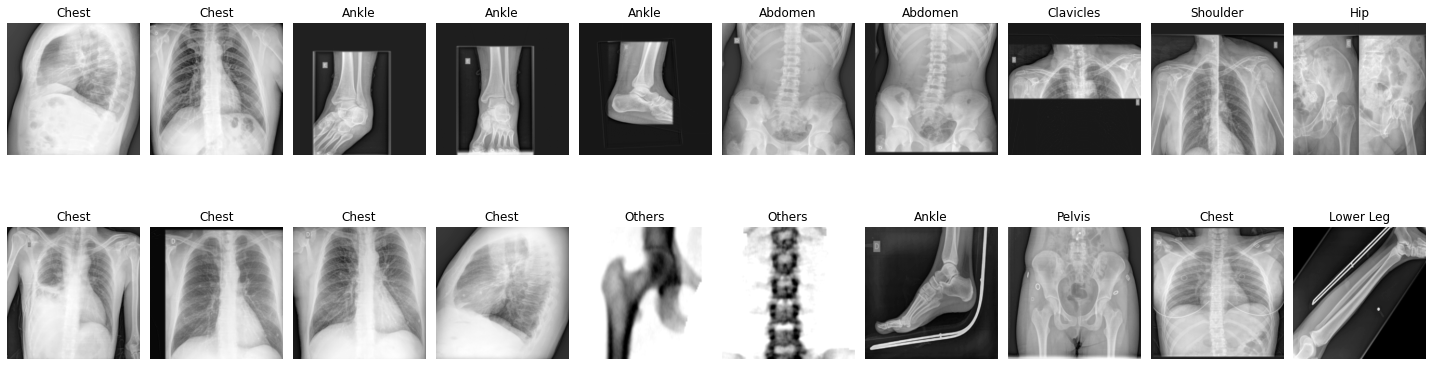

In [9]:
plt.figure(figsize=(20,20))
show_images(train_files, 20, class_names = train_data['Label'])

In [10]:
image_count = len(list(train_files))
print(image_count)


1738


In [11]:
import pathlib
train_dir = pathlib.Path('train/train/train')

In [12]:
image_count = len(list(train_dir.glob('*/*/*/*')))
print(image_count)

1738


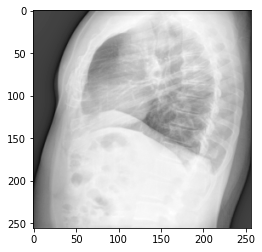

In [13]:
temp = list(train_dir.glob('*/*/*/*'))
plt.imshow(pydicom.dcmread(str(temp[0])).pixel_array, cmap='binary', interpolation='bilinear')


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_files,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


NameError: name 'img_height' is not defined

In [15]:
y_train = MultiLabelBinarizer().fit_transform(y_train)

In [16]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
# X_train.to_numpy().reshape(-1, 256, 256)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = tf.convert_to_tensor(X_train)


In [18]:
train_size = int(0.7 * 1738)
val_size = int(0.15 * 1738)
test_size = int(0.15 * 1738)

full_dataset = train_dataset.shuffle(32)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

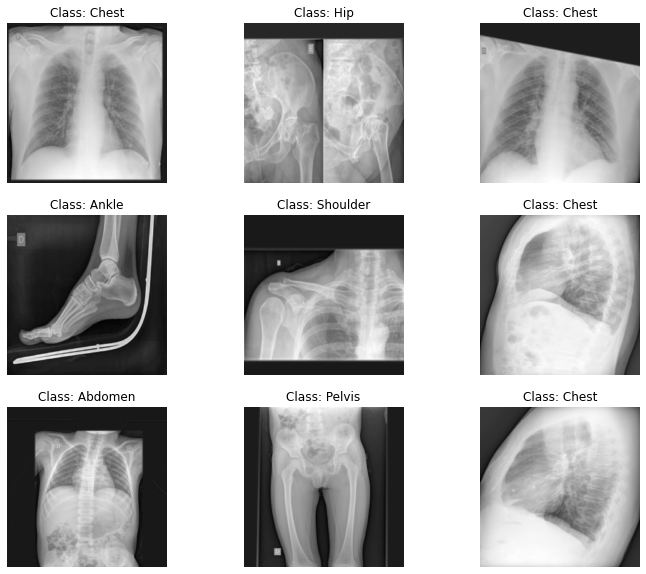

In [19]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_dataset.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(np.array(image).reshape(256, 256), cmap='binary', interpolation='bilinear')
    plt.title("Class: {}".format(classes_to_body_parts[np.argmax(label)]))
    plt.axis("off")

plt.show()

In [28]:
def preprocess(image, label):
    print(image.shape)
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [29]:
batch_size = 32
train_set = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
valid_set = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_dataset.map(preprocess).batch(batch_size).prefetch(1)

(65536,)


ValueError: in user code:

    File "/var/folders/0v/c3_5nsbs1hx8pz00k835sfy40000gp/T/ipykernel_36629/3298787618.py", line 3, in preprocess  *
        resized_image = tf.image.resize(image, [224, 224])

    ValueError: 'images' must have either 3 or 4 dimensions.
